## Initial data transformation and processing

In [64]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error
from math import ceil

import utils as ut
reload(ut)
%matplotlib inline

In [2]:
data_array = sio.loadmat('data/DATASET.mat')['DATASET']

We'll keep only HRIRs and HRTFs

In [5]:
# Get only real part
data_float = data_array.copy().real.astype(float)
# Array with all variables as float (includding imaginary part as a separate variable)
all_float_array = np.hstack((data_float[:, :596], data_float[:, 996:]))

In [6]:
# Imaginary components are now separated
print 'original dataset shape:', data_array.shape
print 'all floats dataset shape:', all_float_array.shape

original dataset shape: (65600, 1039)
all floats dataset shape: (65600, 639)


Now we will include feature names:

In [7]:
def define_column_names():
    column_names = []
    # Time series
    for i in range(200):
        column_names.append('L_HRIR_{:d}'.format(i))
    for i in range(200):
        column_names.append('R_HRIR_{:d}'.format(i))

    # Frequency Series
    for i in range(98):
        column_names.append('L_HRTF_{:d}'.format(i))
    for i in range(98):
        column_names.append('R_HRTF_{:d}'.format(i))

    # Complex Response
    '''for i in range(200):
        column_names.append('L_FFT_real_{:d}'.format(i))
    for i in range(200):
        column_names.append('R_HRIR_real_{:d}'.format(i))
    for i in range(200):
        column_names.append('L_FFT_imag_{:d}'.format(i))
    for i in range(200):
        column_names.append('R_HRIR_imag_{:d}'.format(i))'''
    # Interaction Parameters
    # Time-arrival Difference
    column_names.append('ITD')
    # Intensity Difference
    column_names.append('IID')
    # Spectral Difference
    column_names.append('DS')
    # Head Parameters
    column_names.append('head_width')
    column_names.append('head_height')
    column_names.append('head_depth')
    column_names.append('pinna_offset_down')
    column_names.append('pinna_offset_back')
    column_names.append('neck_width')
    column_names.append('neck_height')
    column_names.append('neck_depth')
    column_names.append('torso_top_width')
    column_names.append('torso_top_heigth')
    column_names.append('torso_top_depth')
    column_names.append('shoulder_width')
    column_names.append('head_offset_forward')
    column_names.append('height')
    column_names.append('seated_height')
    column_names.append('head_circumference ')
    column_names.append('shoulder_circumference')

    # Ear Parameters
    column_names.append('L_cavum_concha_heigth')
    column_names.append('L_cymba_concha_heigth')
    column_names.append('L_cavum_concha_width')
    column_names.append('L_fossa_height')
    column_names.append('L_pinna_height')
    column_names.append('L_pinna_width')
    column_names.append('L_intertragal_incisure_width')
    column_names.append('L_cavum_concha_depth')
    column_names.append('R_cavum_concha_heigth')
    column_names.append('R_cymba_concha_heigth')
    column_names.append('R_cavum_concha_width')
    column_names.append('R_fossa_height')
    column_names.append('R_pinna_height')
    column_names.append('R_pinna_width')
    column_names.append('R_intertragaR_incisure_width')
    column_names.append('R_cavum_concha_depth')

    # Pinnae Rotation Parameters
    column_names.append('L_pinna_rotation_angle')
    column_names.append('L_pinna_flare_angle')
    column_names.append('R_pinna_rotation_angle')
    column_names.append('R_pinna_flare_angle')

    # Target
    column_names.append('azimuth')
    column_names.append('elevation')

    # Subject Id
    column_names.append('subject_id')
    return column_names

In [8]:
column_names = define_column_names()

In [12]:
# Build Pandas DataFrame
df = pd.DataFrame(all_float_array, columns=column_names)

In [16]:
# col_ix Dictionary can be used to get the index of any feature
col_ix = {}
for i, col in enumerate(df.columns):
    col_ix[col] = i

In [17]:
# Should match the number of colums in dataset
len(column_names)

639

### Number of unique azimuth, elevation and subject_id values

In [18]:
print 'azimuth: \nunique', df.azimuth.nunique(), '\n', df.azimuth.describe().transpose()
print 'elevation: \n unique', df.elevation.nunique(), df.elevation.describe().transpose()
print 'subject_id:', df.subject_id.nunique()

azimuth: 
unique 60 
count    65600.000000
mean        -4.321646
std        107.656501
min       -180.000000
25%       -100.000000
50%         -0.000000
75%         80.000000
max        175.000000
Name: azimuth, dtype: float64
elevation: 
 unique 32 count    65600.000000
mean        17.841797
std         40.146042
min        -50.625000
25%        -16.875000
50%         16.875000
75%         50.625000
max         90.000000
Name: elevation, dtype: float64
subject_id: 95


Full dataset contains data from two original datasets.

For the moment we will work with the first dataset only.

In [19]:
ds_1 = df.ix[:56249].copy()
ds_1.shape

(56250, 639)

In [20]:
# TOTAL Unique Subjects for dataset 1 = 45
ds_1.loc[:, ('subject_id')] = ds_1['subject_id'].astype(int)
ds_1.subject_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

## Inter-subject variation for same azimuth and elevation angles

In [13]:
df.elevation.unique()

array([-45.   , -39.375, -33.75 , -28.125, -22.5  , -16.875, -11.25 ,
        -5.625,   0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,
        33.75 ,  39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,
        73.125,  78.75 ,  84.375,  90.   , -50.625, -30.   , -15.   ,
        15.   ,  30.   ,  60.   ,  75.   ])

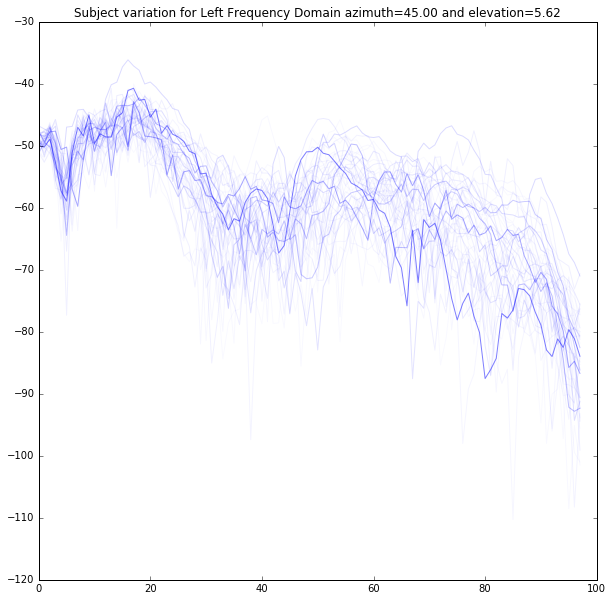

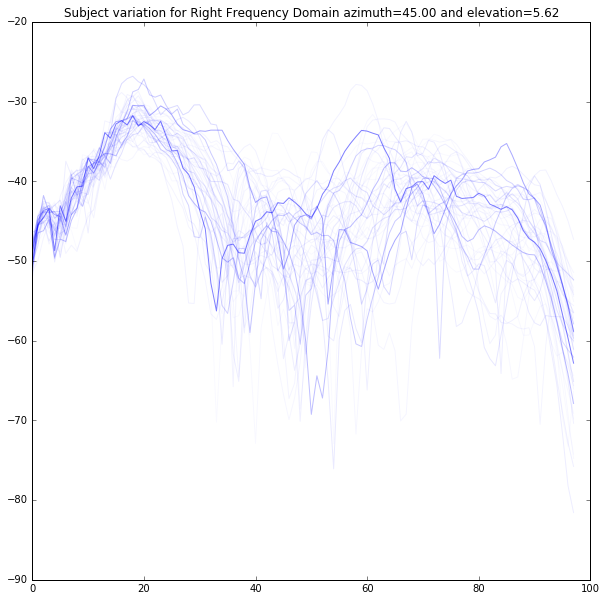

In [15]:
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 5.625
location = ds_1[(ds_1.azimuth == azimuth) & (ds_1.elevation == elevation)]
l_range = range(400, 498)
r_range = range(498, 596)
l_hrtf = location.iloc[:,l_range]
r_hrtf = location.iloc[:, r_range]
j = 1
plt.figure(figsize=(10, 10))
for i in range(1, 45):
    first = l_hrtf[location.subject_id == i].iloc[0]
    plt.plot(range(len(l_range)), first, c='b', alpha=1.0/(j+1))
    j += 1
plt.title('Subject variation for Left Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

j = 1
plt.figure(figsize=(10, 10))
for i in range(1, 45):
    first = r_hrtf[location.subject_id == i].iloc[0]
    plt.plot(range(len(r_range)), first, c='b', alpha=1.0/(j+1))
    j += 1
#plt.legend(loc='upper right')
plt.title('Subject variation for Right Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

By Analayzing non-HRTF features (measurements of subjects) we discover that dome of them are missing, so we decide to substitute missing values with the mean of each feature.

In [16]:
ds_1.ix[:, 1399:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
head_width,46250.0,14.428826,0.905161,12.646597,13.903307,14.443268,14.892092,16.203902
head_height,46250.0,21.377795,1.161957,18.865526,20.665188,21.311794,22.090244,23.842658
head_depth,46250.0,19.900724,1.312059,16.660570,19.275830,19.915320,20.870571,23.064239
pinna_offset_down,46250.0,3.006494,0.586056,1.408322,2.446867,3.220209,3.469709,3.772236
pinna_offset_back,46250.0,0.389666,0.590552,-1.170696,0.167971,0.393765,0.785692,1.899457
neck_width,46250.0,11.518612,0.997720,9.408768,11.020129,11.549176,12.212968,14.042607
neck_height,46250.0,6.177656,1.972471,1.905978,4.982187,6.340924,7.461400,10.600237
neck_depth,46250.0,10.477648,1.134602,7.837414,9.936521,10.372081,11.325472,12.534256
torso_top_width,46250.0,30.953683,2.606181,25.202642,29.566625,31.213773,32.422859,36.839476
torso_top_heigth,46250.0,13.429684,1.939632,9.412423,12.236193,13.005980,14.494436,17.560892


### Is subject variation really important?
Test: build model with subject id as categorical variable. If subject variation exist these features should be important.

In [119]:
from sklearn.preprocessing import OneHotEncoder

range_ = range(0,596) + range(-3,0)
ds_subject = ds_1.ix[:, range_].copy()

azimuth = ds_subject['azimuth']
elevation = ds_subject['elevation']
ds_subject.drop(['azimuth', 'elevation'], axis=1, inplace=True)

# Substitute missing values with feature mean
means = ds_subject.mean(axis=0)
ds_subject = ds_subject.fillna(means)

enc = OneHotEncoder()
enc = enc.fit(np.array(ds_subject.ix[:, 'subject_id']).reshape(-1, 1))
res = enc.transform(np.array(ds_subject.ix[:, 'subject_id']).reshape(-1, 1))

In [120]:
res_featues = res.toarray().transpose()
for i, feature in enumerate(res_featues):
    if i == res_featues.shape[0]:
        break # Only n - 1 dummies are necessary to represent n values
    ds_subject['subject_id_' + str(i)] = feature

In [121]:
ds_subject = pd.concat([ds_subject, elevation, azimuth], axis=1)
train, val, test = get_splitted_dataset(ds_subject)
train = train.drop('subject_id', axis=1)
val = val.drop('subject_id', axis=1)
test = test.drop('subject_id', axis=1)

### Subject id model for Elevation

In [122]:
X_train, y_train = train.ix[:, :-2], train.ix[:, 'elevation']
X_val, y_val = val.ix[:, :-2], val.ix[:, 'elevation']
X_test, y_test = test.ix[:, :-2], test.ix[:, 'elevation']
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(42500, 641) (42500,)
(7500, 641) (7500,)


In [123]:
depth = 20
regr = DecisionTreeRegressor(max_depth=depth)
regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [124]:
# Predict on training data
y_pred_train = regr.predict(X_train)
loss_train = mean_absolute_error(y_train, y_pred_train)
# Predict on test data
y_pred = regr.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)
y_pred_val = regr.predict(X_val)
loss_val = mean_absolute_error(y_val, y_pred_val)
print 'train', loss_train
print 'validation', loss_val
print 'test', loss

train 0.780964657491
validation 17.5644791993
test 16.1721396536


In [125]:
importances = pd.Series(regr.feature_importances_, index=X_train.columns)

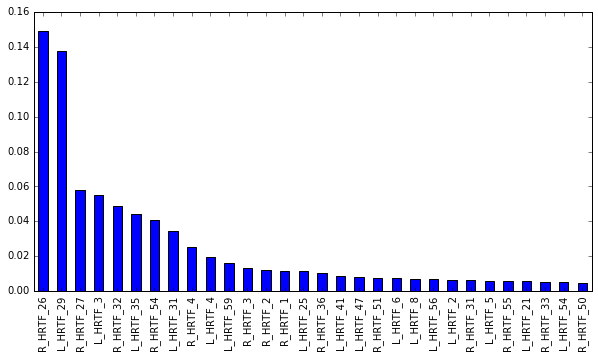

In [126]:
# More informative features
importances.sort_values(ascending=False, inplace=True)
importances[:30].plot(kind='bar', figsize=(10,5))

In [127]:
# Less informative features
importances.sort_values(ascending=True, inplace=True)
importances[:40]

L_HRIR_0         0.000000e+00
subject_id_44    0.000000e+00
R_HRIR_0         0.000000e+00
subject_id_43    0.000000e+00
subject_id_41    0.000000e+00
subject_id_40    0.000000e+00
subject_id_39    0.000000e+00
subject_id_37    0.000000e+00
subject_id_31    0.000000e+00
subject_id_29    0.000000e+00
subject_id_28    0.000000e+00
subject_id_26    0.000000e+00
subject_id_25    0.000000e+00
subject_id_24    0.000000e+00
subject_id_0     0.000000e+00
subject_id_21    0.000000e+00
subject_id_2     0.000000e+00
subject_id_6     0.000000e+00
subject_id_7     0.000000e+00
subject_id_8     0.000000e+00
subject_id_9     0.000000e+00
subject_id_10    0.000000e+00
subject_id_23    0.000000e+00
subject_id_13    0.000000e+00
subject_id_20    0.000000e+00
subject_id_19    0.000000e+00
subject_id_11    0.000000e+00
subject_id_14    0.000000e+00
subject_id_18    0.000000e+00
subject_id_36    3.014093e-07
subject_id_15    3.014093e-07
subject_id_32    4.069025e-07
subject_id_35    4.144378e-07
subject_id

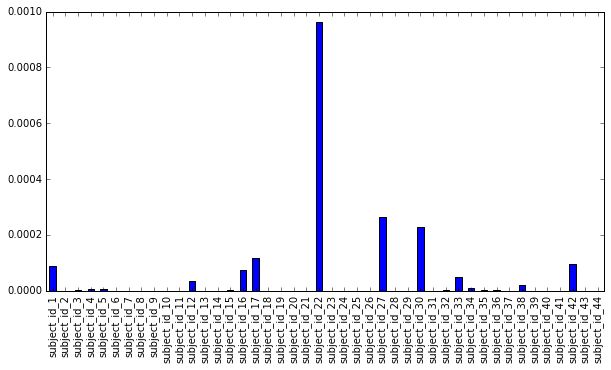

In [128]:
importances[X_train.columns[-44:]].plot(kind='bar', figsize=(10,5))

### Subject id model for azimuth

Could you please do the same analysis for azimuth?